# Лабораторная работа (4) по GAN

**Введение**

В этой лабораторной работе мы будем работать с генерирующей состязательной сетью (GAN), которая является мощным инструментом для генерации изображений, текстов и других типов данных. GAN состоят из двух нейронных сетей: генератора и дискриминатора. Генератор пытается создать новые объекты, которые похожи на обучающие примеры, а дискриминатор пытается отличить реальные примеры от фальшивых.

В этой лабораторной работе мы будем работать с набором данных MNIST, который состоит из 6200 ч/б изображений размером 28x28 пикселя. Мы будем использовать генеративную модель для создания изображений, которые похожи на изображения из набора данных MNIST.

Цель работы

Целью данной лабораторной работы является изучение принципов работы генерирующих состязательных сетей (GAN) и применение их для создания изображений.

**Необходимо:**

Загрузить данные набора данных MNIST.

Предобработать данные.

Разбить данные на обучающую и тестовую выборки.

Создать и обучить базовые сети генератора и дискриминатора.

Оценить качество модели и проанализировать результат.

Попробовать улучшить качество модели, экспериментируя с гиперпараметрами и архитектурой модели.

Импорт библиотек

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

Загрузка данных. Выберем в качестве данных изображения цифры 7. Установим размер бэтча.

(6240, 28, 28) (6240,)


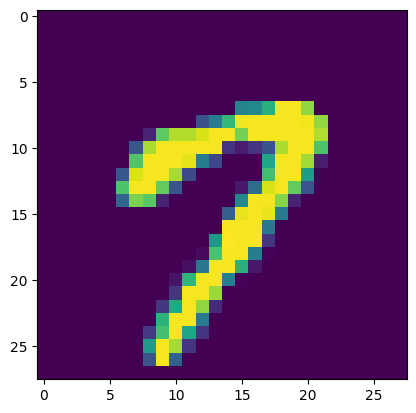

In [4]:
# Загрузка набора данных
import matplotlib 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[y_train == 7]
y_train = y_train[y_train == 7]

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 32

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(x_train.shape, y_train.shape)
plt.imshow(x_train[0])

In [5]:
# стандартизация входных данных
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) #значения пикселей от 0 до  1, 1 канал (ч/б) изображение
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [6]:
# формирование сетей
hidden_dim = 2

In [7]:
def dropout_and_batch():
  return Dropout(0.3)(BatchNormalization())

**Создание генератора**

Теперь мы создадим генератор, который будет принимать на вход случайный шум и генерировать изображения.

In [8]:
# генератор
generator = tf.keras.Sequential([
  Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)),
  BatchNormalization(),
  Reshape((7, 7, 256)),
  Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')
])

**Создание дискриминатора**

Теперь мы создадим дискриминатор, который будет принимать на вход изображение и выводить вероятность того, что оно является реальным.

In [9]:
# дискриминатор
discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))


Функция потерь для  генератора и дискриминатора

In [10]:
# потери
lossf = cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)  #(from_logits=True)

In [11]:
def generator_loss(fake_output):
  loss = lossf(tf.ones_like(fake_output), fake_output)
  return loss

In [12]:
def discriminator_loss(real_output, fake_output):
  real_loss = lossf(tf.ones_like(real_output), real_output)
  fake_loss = lossf(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

Оптимизатор для генератора и дискриминатора используем Adam

In [13]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

Функции для обучения

In [14]:
# обучение
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, hidden_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [15]:
def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

  for epoch in range(1, epochs + 1):
    print(f'{epoch}/{EPOCHS}: ', end='')

    start = time.time()
    n = 0

    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      if (n % th == 0): print('=', end='')
      n += 1

    history += [gen_loss_epoch / n]
    print(': ' + str(history[-1]))
    print('Время эпохи {} составляет {} секунд'.format(epoch, time.time() - start))

  return history

Запуск процесса обучения. 

1/300: ===========: tf.Tensor(0.80588245, shape=(), dtype=float32)
Время эпохи 1 составляет 2.5552873611450195 секунд
2/300: ===========: tf.Tensor(0.8135115, shape=(), dtype=float32)
Время эпохи 2 составляет 1.726123571395874 секунд
3/300: ===========: tf.Tensor(0.8171861, shape=(), dtype=float32)
Время эпохи 3 составляет 1.4460291862487793 секунд
4/300: ===========: tf.Tensor(0.79473174, shape=(), dtype=float32)
Время эпохи 4 составляет 1.4566223621368408 секунд
5/300: ===========: tf.Tensor(0.7841007, shape=(), dtype=float32)
Время эпохи 5 составляет 1.454653024673462 секунд
6/300: ===========: tf.Tensor(0.79251933, shape=(), dtype=float32)
Время эпохи 6 составляет 1.4606084823608398 секунд
7/300: ===========: tf.Tensor(0.7942791, shape=(), dtype=float32)
Время эпохи 7 составляет 1.7326979637145996 секунд
8/300: ===========: tf.Tensor(0.80308354, shape=(), dtype=float32)
Время эпохи 8 составляет 1.5423574447631836 секунд
9/300: ===========: tf.Tensor(0.8834245, shape=(), dtype=float

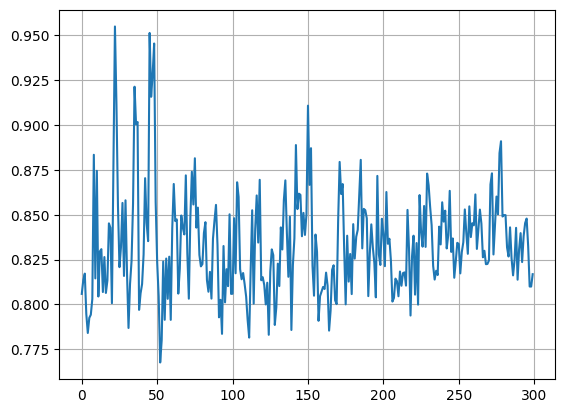

In [22]:
EPOCHS = 300
history = train(train_dataset, EPOCHS)

plt.plot(history)
plt.grid(True)
plt.show()

Визуализация

In [20]:
# отображение результатов генерации
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1/1 [==============================] - 0s 18ms/step


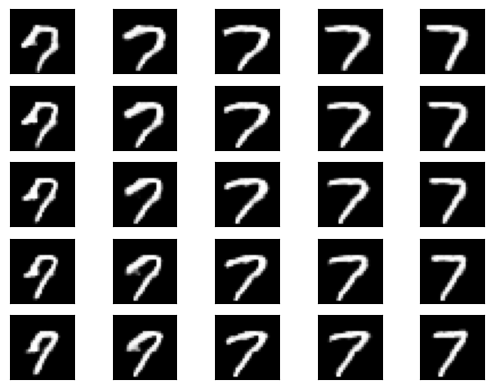

In [23]:
num = 1
for i in range(-n, n + 1):
  for j in range(-n, n + 1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
    plt.imshow(img[0, :, :, 0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

В результате процесса обучения установлено 300 эпох обучения, оптимизатор Adam и бинарная кросс-энтропия в качестве функции потерь. С увеличением количества эпох обучения наблюдается улучшение результатов тестирования модели.

**Вывод:** в ходе выполнения работы создана сеть генератора и дискриминатора, установлены размер бэтча, количество эпох обучения, функция потерь и оптимизатор.

Модификация модели

Ваша задача - дополнить код и модифицировать данный ноутбук. Необходимо дополнить следующие параметры:

* Создать сеть генератора и дискриминатора.
* Установить
  * Размер батча
  * Количество эпох обучения
  * Функцию потерь
  * Оптимизаторы

**Оценка работы**

Оценка работы будет производиться на основе полученных результатов. Необходимо предоставить отчет, в котором будет содержаться:

* Описание проведенных модификаций
* Графики обучения модели
* Результаты тестирования модели
* Код

Успехов в выполнении лабораторной работы!